# Running Experiments on CrisisLexT26 Dataset
The initial project used the CrisisLexT26 dataset, [here](https://crisislex.org/data-collections.html#CrisisLexT26), and ran four experiments. Of the four experiments, two attempted to match crowd-sourced data in the CrisisLexT26 dataset with data produced from a large language model whilst the other two focused on metadata. The four experiments were:

- **Informativeness**,
- **Information Type**,
- **Crisis Type**, and
- **Country Impacted**.

These experiments were run to understand how well a generic large language model would perform labelling unseen data. For this project zero-shot prompting was used.

This notebook has been set up to enable anyone to run the experiments and receive results. The members of the project do add the caveat that large language models are designed to communicate like humans. What has not been tested, as part of this work, is do large language models produce different results to the same question. The assumption is they can but through prompting the project team has tried to ensure reprodicable results but can not guarantee results from one run to the next.

### Before Starting
Create a Hugging Face account and generate a private token. A Hugging Faqce private token is required for accessing large language models (LLMs).

### Step 1 - Clone the project GitHub repo
The experiments run as part of this project can be replicated using code stored in the publicly available GitHub repo [here](https://github.com/Crisitunity-Lab/ARDC-Project). To access parsers, response collection fucntions and evaluators, clone the GitHub repo to the local environment.

In [1]:
# Clone GitHub repo
user = "Crisitunity-Lab"
repo = "ARDC-Project"

!git clone https://github.com/$user/$repo /content/repo

Cloning into '/content/repo'...
remote: Enumerating objects: 494, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 494 (delta 25), reused 34 (delta 14), pack-reused 437
Receiving objects: 100% (494/494), 5.20 MiB | 10.05 MiB/s, done.
Resolving deltas: 100% (253/253), done.


### Step 2 Install requirements
All python library requirements for this experiment are contained in a requirements.txt file and can be run with the below.

In [2]:
%pip install -r /content/repo/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 23.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 117.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 7.

In [3]:
# Import langchain library
from langchain import HuggingFacePipeline

# Import bespoke functions
import repo.src.structure_extractor.data_utils as du
import repo.src.structure_extractor.model_utils as mu

# Step 3 Get data
Using the pre-built functions in the data utils file, provide a link to the zipped data and a destination directory. Data will be downloaded and unzipped to the destination directory. The source dataset contains multiple files in each directory. The files include in each directory include:
- A README.md file containing general information about the files in the folder.
- A JSON file containing information about the event and other pieces of metadata.
- A labelled tweets comma separated values (CSV) file named \<crisis_event>-
tweets_labeled.csv. This file contains labelled tweets.
- A CSV file containing a list of identifiers for all tweets associated with the event. The file is
named \<crisis_event>-tweetids_entire_period.csv.

For this experiment only the _\<crisis_event>-tweets_labeled.csv_ is required.

In [4]:
# Get data from online source and unzip to local directory
zip_file_url = "https://github.com/sajao/CrisisLex/blob/master/releases/CrisisLexT26-v1.0.zip?raw=true"
dest_folder = "/content/data/"

du.unzip_from_url(src=zip_file_url, dest=dest_folder)

Download and Unzip complete


Data is now stored at /content/data/CrisisLexT26 within the Google Colab environment.

###Step 4 Combine data into single dataframe
As the data is spread across multiple CSV files the *combine_csv_files* function will bring together the tweets_labelled file in each directory in a single file.

**NOTE**: Some tweets in the dataset have very few words. Having little data in the tweet makes it difficult for anyone, let alone a large language model, to understand what the tweet is about. The minimum length of a tweet can be set and tweets with fewer words than the minimum are excluded. "Words" doesn't include hashtags, links and user tags.  

In [5]:
# Set the folder name for where the data is stored
data_folder_name = "CrisisLexT26"
data_loc = dest_folder + data_folder_name
min_tweet_length = 6

# Combine csv's into a single dataframe. By default the folder the data is stored in is included as a
# new field called "label", but this can be turned off by setting the retrieve_label parameter to False.
df = du.combine_csv_files(data_loc, min_tweet_len=min_tweet_length)

In [6]:
# Data is now in a nice dataframe
df.head(10)

,Tweet ID,Tweet Text,Information Source,Information Type,Informativeness,label,year,country_code,crisis_type
0,203440928084602880,E #Navelli... a che punto siamo? Dov'è il pian...,Outsiders,Other Useful Information,Related - but not informative,2012_Italy_earthquakes,2012,IT,Earthquake
1,203843778409283584,"RT @andmarini: #Modena Strage di Brindisi, all...",Not labeled,Not labeled,Not related,2012_Italy_earthquakes,2012,IT,Earthquake
2,204030290715348993,#Terremoto ! in alto si sente parecchio,Outsiders,Sympathy and support,Related - but not informative,2012_Italy_earthquakes,2012,IT,Earthquake
3,204030617850089472,Inequivocabilmente questa era una scossa di #t...,Eyewitness,Sympathy and support,Related - but not informative,2012_Italy_earthquakes,2012,IT,Earthquake
5,204032853439283201,"“@perugini: 44.956°N, 11.241°E - 4.2 Magnitudo...",Eyewitness,Other Useful Information,Related and informative,2012_Italy_earthquakes,2012,IT,Earthquake
6,204033939772407808,RT @Reuters: BREAKING NEWS: 6.3 magnitude eart...,Media,Other Useful Information,Related and informative,2012_Italy_earthquakes,2012,IT,Earthquake
7,204033969124155392,RT @Reuters: BREAKING NEWS: 6.3 magnitude eart...,Media,Other Useful Information,Related and informative,2012_Italy_earthquakes,2012,IT,Earthquake
9,204034510176780288,RT @Reuters: BREAKING NEWS: 6.3 magnitude eart...,Media,Other Useful Information,Related and informative,2012_Italy_earthquakes,2012,IT,Earthquake
11,204034585670062080,"RT @USGSted: Strong earthquake, NORTHERN ITALY...",Media,Caution and advice,Related and informative,2012_Italy_earthquakes,2012,IT,Earthquake
12,204034644398702592,Oddio #terremoto. L'ho sentito solo io alle 4...,Eyewitness,Sympathy and support,Related - but not informative,2012_Italy_earthquakes,2012,IT,Earthquake


In [7]:
len(df)

26001

###Step 5 Log in to Hugging Face
Hugging Face is a data science platform that provides tools to build, train and deploy machine learning models. In addition, it acts as a community where ideas can be shared, and peer-to-peer support can be provided. Hugging Face hosts a variety of machine learning models, including many LLMs.

For this project LLMs hosted on Hugging Face were used. To access Hugging Face need to log in with a private token. To retrieve a token users of this notebook will need to create a Hugging Face account and create a private token. **Note** university accounts did not gain access to LLMs created by Meta.

In [8]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


###Step 6 Download Model
For this experiment Meta AI's Llama2-7b-chat model was used. The model can be downloaded from Hugging Face, once appropriate permissions have been granted by Meta.

In [9]:
# Set model to run experiments on
model = "meta-llama/Llama-2-7b-chat-hf"

# Download model to local environment
pipeline = mu.download_hf_model(model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

###Step 7 Load Selected Model
After downloading the desired model it needs to be loaded into the local environment.

At this stage the models temperature can be set. For these experiments the temperature was set to zero to reduce variance produced by the model.

In [10]:
# Load selected model
# Set temperature to desired value to determine "creativity" of the model
llm = HuggingFacePipeline(pipeline = pipeline, model_kwargs = {'temperature':0})

###Step 8 Create Prompts and Retieve a Response
To interface with LLMs a user needs to send a prompt with the request for the model. The below is an example of a **system prompt** and an **instruction** used for information type experiment. This wording can be changed. Changing the prompt will impact output.

####Zero-Shot Prompting
The prompts used in the experiment were zero-shot prompts. Zero-shot prompts ask the model to perform a task on previously unseen data without any examples of expected responses. There are other prompting techniques, like few-shot prompting and chain-of-thought prompting. These other techniques were not used in the experiments run by the project team.

In [11]:
# Set System Prompt
system_prompt = "You are a crisis researcher that excels at classifying whether the text contains useful information in relation to a crisis. Stop after giving one answer. " \
"Only return one label that is the most appropriate. "

# Set Instruction
instruction = '''"Classify using these following labels which are defined as follows:
"Caution and advice for residents"= Warnings issues or lifted, guidance, and tips.
"Affected residents"= Casualties due to the crisis. Questions and/or reports about missing, trapped, displaced, evacuated or found people.
"Infrastructure and utilities damage"= Buildings or roads damaged or operational; utilities/services interrupted or restored.
"Donations or volunteering"= Needs or donations of supplies such as food, water, clothing, medical supplies or blood. Services needed or offered by volunteers or professionals.
"expressing Sympathy and support for affected"= Status updates about individuals or loved ones; emotional support, thoughts and prayers.
"other useful information"= Other information that is useful to a crisis.
"Not applicable"= No information related to a crisis.

Return one label with explanation.
"{text}" "'''

# Contruct prompt from system prompt and instruction
prompt_template = mu.get_prompt_template(instruction, system_prompt)

# Create new dataframe for experiment - limiting to one record to ensure process deosn't run for hours
test_df = df[df["Tweet ID"].isin([204034510176780288,204030617850089472])]

# Create an empty response column in test_df
test_df['llm_information_type'] = ""

# Loop over rows in test dataframe
for index, row in test_df.iterrows():
    message = row['Tweet Text']
    # Add response from model to dataframe
    test_df.loc[index, 'llm_information_type'] = mu.generate_answer(message, prompt_template, llm)

# Check data in dataframe
test_df.head()

<ipython-input-11-a8dd95746a52>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['llm_information_type'] = ""


,Tweet ID,Tweet Text,Information Source,Information Type,Informativeness,label,year,country_code,crisis_type,llm_information_type
3,204030617850089472,Inequivocabilmente questa era una scossa di #t...,Eyewitness,Sympathy and support,Related - but not informative,2012_Italy_earthquakes,2012,IT,Earthquake,"Label: ""Affected residents""\n\nThis text ref..."
9,204034510176780288,RT @Reuters: BREAKING NEWS: 6.3 magnitude eart...,Media,Other Useful Information,Related and informative,2012_Italy_earthquakes,2012,IT,Earthquake,"Label: ""Affected residents""\n\nExplanation: ..."


In [12]:
%cd repo

/content/repo


###Step 9 Output Parsing
Response from the models investigated were always in a string format and often contained verbose or non-deterministic output.

####Extract Results
The response from the model was often in JSON-like text and the first step in the output parser is to extract the required information from the text. The output parser looks for keywords and captures results.

####Standard Output
The second function of the output parser was to standardise labels. In these experiments LLM's returned a variety of responses for the same thing. As an example, when labelling a tweet for a fire event the model may return a crisis type of:

- Fire
- Fire Crisis
- Crisis: Fire
- Fire. The text relates to a fire.

Although these responses are all correct retrieving analysing data with such varied responses is problematic. To resolve this the output parsers condensed response to a standard set of response for analysis.

In [14]:
import src.structure_extractor.parsers as p

test_df['parsed_response']=test_df.apply(lambda row: p.parse_label_infotype(row['llm_information_type']), axis=1)

<ipython-input-14-48d69928bf1f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['parsed_response']=test_df.apply(lambda row: p.parse_label_infotype(row['llm_information_type']), axis=1)


In [15]:
# Show results after parsing
test_df.head()

,Tweet ID,Tweet Text,Information Source,Information Type,Informativeness,label,year,country_code,crisis_type,llm_information_type,parsed_response
3,204030617850089472,Inequivocabilmente questa era una scossa di #t...,Eyewitness,Sympathy and support,Related - but not informative,2012_Italy_earthquakes,2012,IT,Earthquake,"Label: ""Affected residents""\n\nThis text ref...",Affected individuals
9,204034510176780288,RT @Reuters: BREAKING NEWS: 6.3 magnitude eart...,Media,Other Useful Information,Related and informative,2012_Italy_earthquakes,2012,IT,Earthquake,"Label: ""Affected residents""\n\nExplanation: ...",Affected individuals


###Step 10 Evaluate Response
By calculating the precision, recall and F1-score of the actuals vs the predicted the performance of the results from the LLM can be evaluated and compared. The below code provides a shortcut to receive evaluation metrics.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

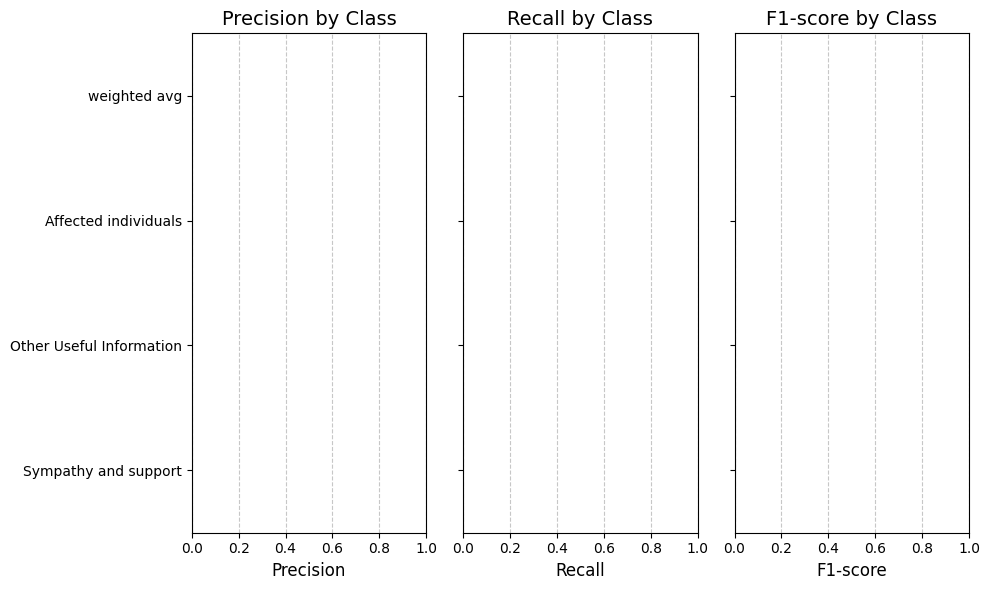

                          precision  recall  f1-score  support
weighted avg                    0.0     0.0       0.0      2.0
Affected individuals            0.0     0.0       0.0      0.0
Other Useful Information        0.0     0.0       0.0      1.0
Sympathy and support            0.0     0.0       0.0      1.0


In [16]:
import src.structure_extractor.evaluation as e

actual = test_df['Information Type']
predicted = test_df['parsed_response']

e.class_metrics(actual_values=actual, predicted_values=predicted)